In [1]:
#rm(list = ls())
set.seed(100)
library(Rtsne)
library(RColorBrewer)
library(pheatmap)
library(dplyr)
library(ggplot2)
library(cowplot)
library(Seurat)
library(Matrix)
library(dat)
library(tidyverse)
library(VennDiagram)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Loading required package: aoos

Attaching package: 'dat'

The following object is masked from 'package:base':

    replace

Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
expand():  tidyr, Matrix
extract(): tidyr, dat
filter():  dplyr, stats
ggsave():  ggplot2, cowplot
lag():     dplyr, stats
map():     purrr, dat
Loading required package: grid
Loading required package: futile.logger


In [2]:
PBMC.8.HTO.HTO.HTODemux.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/PBMC.8.HTO/PBMC.8.HTO.HTO.sample.classifications.HTODemux.csv")
PBMC.8.HTO.HTO.MULTIseqDemux.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/PBMC.8.HTO/PBMC.8.HTO.HTO.sample.classifications.MULTIseqDemux.csv")
PBMC.8.HTO.HTO.GMM.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/PBMC.8.HTO/PBMC.8.HTO.HTO.sample.classifications.GMM.csv")[,2:3]

#comb.counts=readRDS("/projects/ucar-lab/danaco/Ground/comb.counts.RDS")
#groundTruth=read.csv("groundTruth.csv")[,2:3]
#groundTruth$BARCODE=as.character(groundTruth$BARCODE)
#groundTruth$S_type=as.character(groundTruth$S_type)
#gr_ids=which(as.character(groundTruth$BARCODE) %in% colnames(comb.counts))
#Scrublet_2.5_dbl_scores=Scrublet_2.5_dbl_scores[gr_ids]
#DemuxletDefault=read.csv("DemuxletDefaultLabels.csv")[,2:3]
#DemuxletDefault$DefDemux_labels=as.character(DemuxletDefault$DROPLET.TYPE)
#DemuxletDefault$DROPLET.TYPE=NULL
#DemuxletDefault %>% dplyr::rename(DefDemux_labels = DROPLET.TYPE)
#DemuxletModified=read.csv("DemuxletModifiedLabels.csv")[,2:3]
#DemuxletModified$ModDemux_labels=as.character(DemuxletModified$DROPLET.TYPE)
#DemuxletModified$DROPLET.TYPE=NULL
#DemuxletDefault %>% dplyr::rename(ModDemux_labels = DROPLET.TYPE)

In [3]:
PBMC.8.HTO.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/PBMC.8.HTO/PBMC.8.HTO.DF.output.barcodes.labels.csv")[,2:3]
colnames(PBMC.8.HTO.DF_dbl_labels)[1]="DF_BARCODE"
colnames(PBMC.8.HTO.DF_dbl_labels)[2]="DF_LABEL"

PBMC.8.HTO.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/PBMC.8.HTO/PBMC.8.HTO.Scr.doublet.scores.0.1exp_rate.csv")$X0
PBMC.8.HTO.Scrublet_dbl_labels=PBMC.8.HTO.Scrublet_dbl_scores
PBMC.8.HTO.Scrublet_dbl_labels[PBMC.8.HTO.Scrublet_dbl_scores>0.25]="Doublet"
PBMC.8.HTO.Scrublet_dbl_labels[PBMC.8.HTO.Scrublet_dbl_scores<=0.25]="Singlet"
PBMC.8.HTO.Scrublet_dbl_labels=data.frame(SCR_BARCODE=PBMC.8.HTO.DF_dbl_labels$DF_BARCODE, SCR_LABEL=PBMC.8.HTO.Scrublet_dbl_labels)

PBMC.8.HTO.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/PBMC.8.HTO/DRS_doublet_table_PBMC.8.HTO..txt", sep="\t",header=T, row.names=1)
rownames(PBMC.8.HTO.DoubDec_dbl_labels)=gsub(x=rownames(PBMC.8.HTO.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(PBMC.8.HTO.DoubDec_dbl_labels)))
X[PBMC.8.HTO.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[PBMC.8.HTO.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
PBMC.8.HTO.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(PBMC.8.HTO.DoubDec_dbl_labels),DD_LABEL=X)

PBMC.8.HTO.Ground.Truth=data.frame(BARCODE=PBMC.8.HTO.DF_dbl_labels$DF_BARCODE, DF_LABEL=PBMC.8.HTO.DF_dbl_labels$DF_LABEL)
PBMC.8.HTO.Ground.Truth=merge(PBMC.8.HTO.Ground.Truth,PBMC.8.HTO.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
PBMC.8.HTO.Ground.Truth=merge(PBMC.8.HTO.Ground.Truth,PBMC.8.HTO.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
PBMC.8.HTO.Ground.Truth=merge(PBMC.8.HTO.Ground.Truth,PBMC.8.HTO.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(PBMC.8.HTO.Ground.Truth)[length(colnames(PBMC.8.HTO.Ground.Truth))]="HTOD_LABEL"
PBMC.8.HTO.Ground.Truth=merge(PBMC.8.HTO.Ground.Truth,PBMC.8.HTO.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(PBMC.8.HTO.Ground.Truth)[length(colnames(PBMC.8.HTO.Ground.Truth))]="MSD_LABEL"
PBMC.8.HTO.Ground.Truth=merge(PBMC.8.HTO.Ground.Truth,PBMC.8.HTO.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(PBMC.8.HTO.Ground.Truth)[length(colnames(PBMC.8.HTO.Ground.Truth))]="GMM_LABEL"

PBMC.8.HTO.SCR.SNG=subset(PBMC.8.HTO.Ground.Truth,SCR_LABEL=="Singlet")
PBMC.8.HTO.SCR.DBL=subset(PBMC.8.HTO.Ground.Truth,SCR_LABEL=="Doublet")
PBMC.8.HTO.DF.SNG=subset(PBMC.8.HTO.Ground.Truth,DF_LABEL=="Singlet")
PBMC.8.HTO.DF.DBL=subset(PBMC.8.HTO.Ground.Truth,DF_LABEL=="Doublet")
PBMC.8.HTO.DD.SNG=subset(PBMC.8.HTO.Ground.Truth,DD_LABEL=="Singlet")
PBMC.8.HTO.DD.DBL=subset(PBMC.8.HTO.Ground.Truth,DD_LABEL=="Doublet")

PBMC.8.HTO.HTOD.NDBL=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL!="Doublet")
PBMC.8.HTO.HTOD.DBL=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL=="Doublet")
PBMC.8.HTO.MSD.NDBL=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL!="Doublet")
PBMC.8.HTO.MSD.DBL=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL=="Doublet")
PBMC.8.HTO.GMM.NDBL=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL!="Doublet")
PBMC.8.HTO.GMM.DBL=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL=="Doublet")

PBMC.8.HTO.HTOD.NSNG=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL!="Singlet")
PBMC.8.HTO.HTOD.SNG=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL=="Singlet")
PBMC.8.HTO.MSD.NSNG=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL!="Singlet")
PBMC.8.HTO.MSD.SNG=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL=="Singlet")
PBMC.8.HTO.GMM.NSNG=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL!="Singlet")
PBMC.8.HTO.GMM.SNG=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL=="Singlet")

PBMC.8.HTO.HTOD.NNGV=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL!="Negative")
PBMC.8.HTO.HTOD.NGV=subset(PBMC.8.HTO.Ground.Truth,HTOD_LABEL=="Negative")
PBMC.8.HTO.MSD.NNGV=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL!="Negative")
PBMC.8.HTO.MSD.NGV=subset(PBMC.8.HTO.Ground.Truth,MSD_LABEL=="Negative")
PBMC.8.HTO.GMM.NNGV=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL!="Negative")
PBMC.8.HTO.GMM.NGV=subset(PBMC.8.HTO.Ground.Truth,GMM_LABEL=="Negative")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [21]:
int_cells <- Reduce(intersect, list(PBMC.8.HTO.HTOD.NSNG$BARCODE, PBMC.8.HTO.GMM.NSNG$BARCODE, 
                                    PBMC.8.HTO.MSD.SNG$BARCODE ))
length(int_cells)

#dim(CZI.PBMC.1.Ground.Truth)
#groundTruth$scr_2.5_labels=groundTruth$scr_2.5_scores
#groundTruth$scr_2.5_labels[groundTruth$scr_2.5_scores>0.25]="DBL"
#groundTruth$scr_2.5_labels[groundTruth$scr_2.5_scores<=0.25]="SNG"

[1] 403

In [22]:
write.csv(int_cells,"/projects/ucar-lab/danaco/bncmrk-dblts/Data/PBMC.8.HTO/PBMC.8.HTO.MSD.excl.SNG.csv")


#dim(CZI.PBMC.1.DoubDec_dbl_scores)

In [9]:
make3=function(vc){
    if (length(vc)==2){
        vc2=c(rep(0,3))
        vc2[1]=vc[1]
        vc2[3]=vc[2]
    }
    vc2
}

ndframe=data.frame(label=rep(c("Doublet","Negative","Singlet"),6),
                   method=rep(c("SCR","DF","DD","HTOD","MSD","GMM"),each=3),
                   percentage=c(make3(100*summary(PBMC.8.HTO.Ground.Truth$SCR_LABEL)/length(PBMC.8.HTO.Ground.Truth$SCR_LABEL)),
      make3(100*summary(PBMC.8.HTO.Ground.Truth$DF_LABEL)/length(PBMC.8.HTO.Ground.Truth$DF_LABEL)),
     make3(100*summary(PBMC.8.HTO.Ground.Truth$DD_LABEL)/length(PBMC.8.HTO.Ground.Truth$DF_LABEL)),       
    (100*summary(PBMC.8.HTO.Ground.Truth$HTOD_LABEL)/length(PBMC.8.HTO.Ground.Truth$DF_LABEL)),
    (100*summary(PBMC.8.HTO.Ground.Truth$MSD_LABEL)/length(PBMC.8.HTO.Ground.Truth$DF_LABEL)),
    (100*summary(PBMC.8.HTO.Ground.Truth$GMM_LABEL)/length(PBMC.8.HTO.Ground.Truth$DF_LABEL))))

p4 <- ggplot() + geom_bar(aes(y = percentage,x=method,  fill = label), data = ndframe,
                           stat="identity")

#gr_2.5_SNG=subset(groundTruth,scr_2.5_labels=="SNG")
#gr_2.5_DBL=subset(groundTruth,scr_2.5_labels=="DBL")
#gr_Dem_SNG=subset(groundTruth,DefDemux_labels=="SNG")
#gr_Dem_DBL=subset(groundTruth,DefDemux_labels=="DBL")
#gr_df_SNG=subset(groundTruth,Df_label=="SNG")
#gr_df_DBL=subset(groundTruth,Df_label=="DBL")

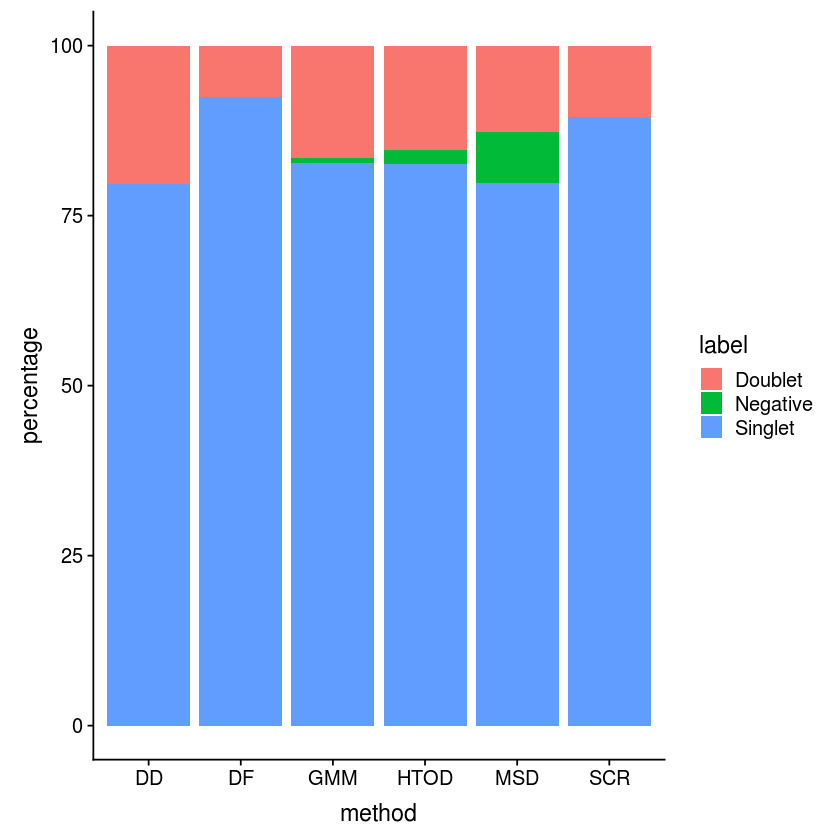

In [10]:
p4
#int_cells <- Reduce(intersect, list(gr.DBL$BARCODE, gr_2.5_SNG$BARCODE, gr_Dem_DBL$BARCODE,gr_df_SNG$BARCODE ))
#length(int_cells)
#sum(gr.SNG$scr_2.5_labels=="SNG")/dim(gr.SNG)[1]
#sum(as.character(groundTruth$S_type)==as.character(DemuxletModified$DROPLET.TYPE))/length(groundTruth$S_type)

In [14]:
int_cells <- Reduce(intersect, list(PBMC.8.HTO.GMM.NGV$BARCODE,PBMC.8.HTO.HTOD.NNGV$BARCODE,
                                    PBMC.8.HTO.MSD.NNGV$BARCODE))
length(int_cells)

dim(PBMC.8.HTO.Ground.Truth)[1]-15171
dim(PBMC.8.HTO.GMM.NSNG)[1]

26419+124233+11538#dim(CZI.PBMC.1.Ground.Truth)
#sum(groundTruth$S_type==as.character(groundTruth$Df_label))/length(groundTruth$S_type)
#sum(gr.DBL$Df_label=="DBL")#/dim(gr.DBL)[1]
#dim(gr_df_DBL)[1]/dim(groundTruth)[1]

Doublet  Negative   Singlet 
12.703949  7.472216 79.823835

In [ ]:
Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0

#Scrublet_2.5_dbl_scores=Scrublet_2.5_dbl_scores[gr_ids]


In [ ]:
demuxSNG=subset(DemuxletDefault, DROPLET.TYPE=="SNG")

In [ ]:
groundTruth=read.csv("groundTruth.csv")


In [ ]:
gr_ids=which(groundTruth$BARCODE %in% colnames(comb.counts))

In [ ]:
#write.csv(groundTruth$BARCODE,"groundTruthBarcodes.csv")

In [ ]:
CZI.PBMC.1.DoubDec_dbl_scores=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.1.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.1.DoubDec_dbl_scores)=gsub(x=rownames(CZI.PBMC.1.DoubDec_dbl_scores),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.1.DoubDec_dbl_scores)))
X[CZI.PBMC.1.DoubDec_dbl_scores$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.1.DoubDec_dbl_scores$isADoublet==FALSE]="Singlet"
CZI.PBMC.1.DoubDec_dbl_scores=data.frame(DD_BARCODE=rownames(CZI.PBMC.1.DoubDec_dbl_scores),DD_label=X)

In [ ]:
CZI.PBMC.1.DoubDec_dbl_scores=data.frame(DD_BARCODE=rownames(CZI.PBMC.1.DoubDec_dbl_scores),DD_label=X)

In [ ]:
dim(CZI.PBMC.1.DoubDec_dbl_scores)

In [ ]:
CZI.PBMC.1.DoubDec_dbl_scores=t(CZI.PBMC.1.DoubDec_dbl_scores)

In [ ]:
CZI.PBMC.1.DF_dbl_scores$BARCODE[1]

In [ ]:
rownames(CZI.PBMC.1.DF_dbl_scores)[1]="DF_BARCODE"

In [ ]:
colnames(CZI.PBMC.1.DF_dbl_scores)[2]="DF_LABEL"

In [ ]:
dim(CZI.PBMC.1.DF_dbl_scores)

In [ ]:
dim(CZI.PBMC.HTO.HTODemux.labels)

In [ ]:
CZI.PBMC.HTO.HTODemux.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/CZI.PBMC/CZI.PBMC.HTO.sample.classifications.HTODemux.csv")
CZI.PBMC.HTO.MULTIseqDemux.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/CZI.PBMC/CZI.PBMC.HTO.sample.classifications.MULTIseqDemux.csv")
CZI.PBMC.HTO.GMM.labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/GroundTruths/CZI.PBMC/CZI.PBMC.HTO.sample.classifications.GMM.csv")[,2:3]


In [ ]:
head(CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.HTODemux.labels$X,1,2)=="1-",])

In [ ]:
CZI.PBMC.1.HTO.HTODemux.labels=CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.HTODemux.labels$X,1,2)=="1-",]

In [ ]:
for(i in 1:10){
    name=paste("CZI.PBMC",i,"HTO",sep=".")
    if (i<10){
    assign(paste(name,"HTODemux.labels",sep="."),CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.HTODemux.labels$X,1,2)==paste(i,"-",sep=""),])
    assign(paste(name,"MULTIseqDemux.labels",sep="."),CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.MULTIseqDemux.labels$X,1,2)==paste(i,"-",sep=""),])
    assign(paste(name,"GMM.labels",sep="."),CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.GMM.labels$Cell_Barcode,1,2)==paste(i,"-",sep=""),])
    }else {
    assign(paste(name,"HTODemux.labels",sep="."),CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.HTODemux.labels$X,1,2)==as.character(i),])
    assign(paste(name,"MULTIseqDemux.labels",sep="."),CZI.PBMC.HTO.HTODemux.labels[substr(CZI.PBMC.HTO.MULTIseqDemux.labels$X,1,2)==as.character(i),])
    assign(paste(name,"GMM.labels",sep="."),CZI.PBMC.HTO.GMM.labels[substr(CZI.PBMC.HTO.GMM.labels$Cell_Barcode,1,2)==as.character(i),])
    }
}

In [ ]:
dim(CZI.PBMC.2.HTO.GMM.labels)

In [ ]:
CZI.PBMC.2.HTO.GMM.labels$X[1]

In [ ]:
CZI.PBMC.1.HTO.MULTIseqDemux.labels$X[1]

In [ ]:
dim(CZI.PBMC.1.DF_dbl_scores)

In [ ]:
summary(CZI.PBMC.1.HTO.HTODemux.labels$x)

In [ ]:
ls()

In [3]:
summary(CZI.PBMC.HTO.MULTIseqDemux.labels$X)

Doublet Negative  Singlet 
   32896    91657   197329

In [5]:
summary(CZI.PBMC.1.HTO.GMM.labels$S_type)

Doublet Negative  Singlet 
   10819      103    21194

In [ ]:
summary(CZI.PBMC.1.HTO.GMM.labels$Cell_Barcode)

In [ ]:
sum(CZI.PBMC.HTO.MULTIseqDemux.labels$x==CZI.PBMC.HTO.GMM.labels$S_type)

In [4]:
set1 <- paste(rep("word_" , 200) , sample(c(1:1000) , 200 , replace=F) , sep="")
set2 <- paste(rep("word_" , 200) , sample(c(1:1000) , 200 , replace=F) , sep="")
set3 <- paste(rep("word_" , 200) , sample(c(1:1000) , 200 , replace=F) , sep="")

In [11]:
venn.diagram(
  x = list(set1, set2, set3),
  category.names = c("Set 1" , "Set 2 " , "Set 3"),
  filename = '#14_venn_diagramm.png',
  output=FALSE
)

[1] 1

In [14]:
CZI.PBMC.2.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.2.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.2.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.2.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.2.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.2.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.2.Scrublet_dbl_labels=CZI.PBMC.2.Scrublet_dbl_scores
CZI.PBMC.2.Scrublet_dbl_labels[CZI.PBMC.2.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.2.Scrublet_dbl_labels[CZI.PBMC.2.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.2.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.2.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.2.Scrublet_dbl_labels)

CZI.PBMC.2.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.2.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.2.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.2.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.2.DoubDec_dbl_labels)))
X[CZI.PBMC.2.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.2.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.2.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.2.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.2.Ground.Truth=data.frame(BARCODE=CZI.PBMC.2.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.2.DF_dbl_labels$DF_LABEL)
CZI.PBMC.2.Ground.Truth=merge(CZI.PBMC.2.Ground.Truth,CZI.PBMC.2.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.2.Ground.Truth=merge(CZI.PBMC.2.Ground.Truth,CZI.PBMC.2.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.2.Ground.Truth=merge(CZI.PBMC.2.Ground.Truth,CZI.PBMC.2.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.2.Ground.Truth)[length(colnames(CZI.PBMC.2.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.2.Ground.Truth=merge(CZI.PBMC.2.Ground.Truth,CZI.PBMC.2.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.2.Ground.Truth)[length(colnames(CZI.PBMC.2.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.2.Ground.Truth=merge(CZI.PBMC.2.Ground.Truth,CZI.PBMC.2.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.2.Ground.Truth)[length(colnames(CZI.PBMC.2.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.2.SCR.SNG=subset(CZI.PBMC.2.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.2.SCR.DBL=subset(CZI.PBMC.2.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.2.DF.SNG=subset(CZI.PBMC.2.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.2.DF.DBL=subset(CZI.PBMC.2.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.2.DD.SNG=subset(CZI.PBMC.2.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.2.DD.DBL=subset(CZI.PBMC.2.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.2.HTOD.NDBL=subset(CZI.PBMC.2.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.2.HTOD.DBL=subset(CZI.PBMC.2.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.2.MSD.NDBL=subset(CZI.PBMC.2.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.2.MSD.DBL=subset(CZI.PBMC.2.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.2.GMM.NDBL=subset(CZI.PBMC.2.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.2.GMM.DBL=subset(CZI.PBMC.2.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [15]:
CZI.PBMC.3.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.3.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.3.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.3.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.3.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.3.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.3.Scrublet_dbl_labels=CZI.PBMC.3.Scrublet_dbl_scores
CZI.PBMC.3.Scrublet_dbl_labels[CZI.PBMC.3.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.3.Scrublet_dbl_labels[CZI.PBMC.3.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.3.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.3.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.3.Scrublet_dbl_labels)

CZI.PBMC.3.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.3.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.3.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.3.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.3.DoubDec_dbl_labels)))
X[CZI.PBMC.3.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.3.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.3.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.3.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.3.Ground.Truth=data.frame(BARCODE=CZI.PBMC.3.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.3.DF_dbl_labels$DF_LABEL)
CZI.PBMC.3.Ground.Truth=merge(CZI.PBMC.3.Ground.Truth,CZI.PBMC.3.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.3.Ground.Truth=merge(CZI.PBMC.3.Ground.Truth,CZI.PBMC.3.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.3.Ground.Truth=merge(CZI.PBMC.3.Ground.Truth,CZI.PBMC.3.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.3.Ground.Truth)[length(colnames(CZI.PBMC.3.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.3.Ground.Truth=merge(CZI.PBMC.3.Ground.Truth,CZI.PBMC.3.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.3.Ground.Truth)[length(colnames(CZI.PBMC.3.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.3.Ground.Truth=merge(CZI.PBMC.3.Ground.Truth,CZI.PBMC.3.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.3.Ground.Truth)[length(colnames(CZI.PBMC.3.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.3.SCR.SNG=subset(CZI.PBMC.3.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.3.SCR.DBL=subset(CZI.PBMC.3.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.3.DF.SNG=subset(CZI.PBMC.3.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.3.DF.DBL=subset(CZI.PBMC.3.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.3.DD.SNG=subset(CZI.PBMC.3.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.3.DD.DBL=subset(CZI.PBMC.3.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.3.HTOD.NDBL=subset(CZI.PBMC.3.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.3.HTOD.DBL=subset(CZI.PBMC.3.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.3.MSD.NDBL=subset(CZI.PBMC.3.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.3.MSD.DBL=subset(CZI.PBMC.3.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.3.GMM.NDBL=subset(CZI.PBMC.3.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.3.GMM.DBL=subset(CZI.PBMC.3.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [16]:
CZI.PBMC.4.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.4.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.4.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.4.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.4.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.4.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.4.Scrublet_dbl_labels=CZI.PBMC.4.Scrublet_dbl_scores
CZI.PBMC.4.Scrublet_dbl_labels[CZI.PBMC.4.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.4.Scrublet_dbl_labels[CZI.PBMC.4.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.4.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.4.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.4.Scrublet_dbl_labels)

CZI.PBMC.4.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.4.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.4.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.4.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.4.DoubDec_dbl_labels)))
X[CZI.PBMC.4.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.4.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.4.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.4.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.4.Ground.Truth=data.frame(BARCODE=CZI.PBMC.4.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.4.DF_dbl_labels$DF_LABEL)
CZI.PBMC.4.Ground.Truth=merge(CZI.PBMC.4.Ground.Truth,CZI.PBMC.4.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.4.Ground.Truth=merge(CZI.PBMC.4.Ground.Truth,CZI.PBMC.4.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.4.Ground.Truth=merge(CZI.PBMC.4.Ground.Truth,CZI.PBMC.4.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.4.Ground.Truth)[length(colnames(CZI.PBMC.4.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.4.Ground.Truth=merge(CZI.PBMC.4.Ground.Truth,CZI.PBMC.4.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.4.Ground.Truth)[length(colnames(CZI.PBMC.4.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.4.Ground.Truth=merge(CZI.PBMC.4.Ground.Truth,CZI.PBMC.4.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.4.Ground.Truth)[length(colnames(CZI.PBMC.4.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.4.SCR.SNG=subset(CZI.PBMC.4.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.4.SCR.DBL=subset(CZI.PBMC.4.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.4.DF.SNG=subset(CZI.PBMC.4.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.4.DF.DBL=subset(CZI.PBMC.4.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.4.DD.SNG=subset(CZI.PBMC.4.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.4.DD.DBL=subset(CZI.PBMC.4.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.4.HTOD.NDBL=subset(CZI.PBMC.4.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.4.HTOD.DBL=subset(CZI.PBMC.4.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.4.MSD.NDBL=subset(CZI.PBMC.4.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.4.MSD.DBL=subset(CZI.PBMC.4.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.4.GMM.NDBL=subset(CZI.PBMC.4.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.4.GMM.DBL=subset(CZI.PBMC.4.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [17]:
CZI.PBMC.5.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.5.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.5.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.5.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.5.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.5.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.5.Scrublet_dbl_labels=CZI.PBMC.5.Scrublet_dbl_scores
CZI.PBMC.5.Scrublet_dbl_labels[CZI.PBMC.5.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.5.Scrublet_dbl_labels[CZI.PBMC.5.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.5.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.5.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.5.Scrublet_dbl_labels)

CZI.PBMC.5.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.5.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.5.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.5.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.5.DoubDec_dbl_labels)))
X[CZI.PBMC.5.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.5.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.5.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.5.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.5.Ground.Truth=data.frame(BARCODE=CZI.PBMC.5.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.5.DF_dbl_labels$DF_LABEL)
CZI.PBMC.5.Ground.Truth=merge(CZI.PBMC.5.Ground.Truth,CZI.PBMC.5.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.5.Ground.Truth=merge(CZI.PBMC.5.Ground.Truth,CZI.PBMC.5.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.5.Ground.Truth=merge(CZI.PBMC.5.Ground.Truth,CZI.PBMC.5.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.5.Ground.Truth)[length(colnames(CZI.PBMC.5.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.5.Ground.Truth=merge(CZI.PBMC.5.Ground.Truth,CZI.PBMC.5.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.5.Ground.Truth)[length(colnames(CZI.PBMC.5.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.5.Ground.Truth=merge(CZI.PBMC.5.Ground.Truth,CZI.PBMC.5.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.5.Ground.Truth)[length(colnames(CZI.PBMC.5.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.5.SCR.SNG=subset(CZI.PBMC.5.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.5.SCR.DBL=subset(CZI.PBMC.5.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.5.DF.SNG=subset(CZI.PBMC.5.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.5.DF.DBL=subset(CZI.PBMC.5.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.5.DD.SNG=subset(CZI.PBMC.5.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.5.DD.DBL=subset(CZI.PBMC.5.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.5.HTOD.NDBL=subset(CZI.PBMC.5.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.5.HTOD.DBL=subset(CZI.PBMC.5.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.5.MSD.NDBL=subset(CZI.PBMC.5.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.5.MSD.DBL=subset(CZI.PBMC.5.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.5.GMM.NDBL=subset(CZI.PBMC.5.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.5.GMM.DBL=subset(CZI.PBMC.5.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.5.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [18]:
CZI.PBMC.7.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.7.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.7.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.7.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.7.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.7.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.7.Scrublet_dbl_labels=CZI.PBMC.7.Scrublet_dbl_scores
CZI.PBMC.7.Scrublet_dbl_labels[CZI.PBMC.7.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.7.Scrublet_dbl_labels[CZI.PBMC.7.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.7.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.7.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.7.Scrublet_dbl_labels)

CZI.PBMC.7.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.7.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.7.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.7.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.7.DoubDec_dbl_labels)))
X[CZI.PBMC.7.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.7.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.7.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.7.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.7.Ground.Truth=data.frame(BARCODE=CZI.PBMC.7.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.7.DF_dbl_labels$DF_LABEL)
CZI.PBMC.7.Ground.Truth=merge(CZI.PBMC.7.Ground.Truth,CZI.PBMC.7.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.7.Ground.Truth=merge(CZI.PBMC.7.Ground.Truth,CZI.PBMC.7.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.7.Ground.Truth=merge(CZI.PBMC.7.Ground.Truth,CZI.PBMC.7.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.7.Ground.Truth)[length(colnames(CZI.PBMC.7.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.7.Ground.Truth=merge(CZI.PBMC.7.Ground.Truth,CZI.PBMC.7.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.7.Ground.Truth)[length(colnames(CZI.PBMC.7.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.7.Ground.Truth=merge(CZI.PBMC.7.Ground.Truth,CZI.PBMC.7.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.7.Ground.Truth)[length(colnames(CZI.PBMC.7.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.7.SCR.SNG=subset(CZI.PBMC.7.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.7.SCR.DBL=subset(CZI.PBMC.7.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.7.DF.SNG=subset(CZI.PBMC.7.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.7.DF.DBL=subset(CZI.PBMC.7.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.7.DD.SNG=subset(CZI.PBMC.7.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.7.DD.DBL=subset(CZI.PBMC.7.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.7.HTOD.NDBL=subset(CZI.PBMC.7.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.7.HTOD.DBL=subset(CZI.PBMC.7.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.7.MSD.NDBL=subset(CZI.PBMC.7.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.7.MSD.DBL=subset(CZI.PBMC.7.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.7.GMM.NDBL=subset(CZI.PBMC.7.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.7.GMM.DBL=subset(CZI.PBMC.7.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.7.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [19]:
CZI.PBMC.9.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.9.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.9.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.9.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.9.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.9.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.9.Scrublet_dbl_labels=CZI.PBMC.9.Scrublet_dbl_scores
CZI.PBMC.9.Scrublet_dbl_labels[CZI.PBMC.9.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.9.Scrublet_dbl_labels[CZI.PBMC.9.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.9.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.9.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.9.Scrublet_dbl_labels)

CZI.PBMC.9.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.9.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.9.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.9.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.9.DoubDec_dbl_labels)))
X[CZI.PBMC.9.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.9.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.9.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.9.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.9.Ground.Truth=data.frame(BARCODE=CZI.PBMC.9.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.9.DF_dbl_labels$DF_LABEL)
CZI.PBMC.9.Ground.Truth=merge(CZI.PBMC.9.Ground.Truth,CZI.PBMC.9.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.9.Ground.Truth=merge(CZI.PBMC.9.Ground.Truth,CZI.PBMC.9.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.9.Ground.Truth=merge(CZI.PBMC.9.Ground.Truth,CZI.PBMC.9.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.9.Ground.Truth)[length(colnames(CZI.PBMC.9.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.9.Ground.Truth=merge(CZI.PBMC.9.Ground.Truth,CZI.PBMC.9.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.9.Ground.Truth)[length(colnames(CZI.PBMC.9.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.9.Ground.Truth=merge(CZI.PBMC.9.Ground.Truth,CZI.PBMC.9.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.9.Ground.Truth)[length(colnames(CZI.PBMC.9.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.9.SCR.SNG=subset(CZI.PBMC.9.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.9.SCR.DBL=subset(CZI.PBMC.9.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.9.DF.SNG=subset(CZI.PBMC.9.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.9.DF.DBL=subset(CZI.PBMC.9.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.9.DD.SNG=subset(CZI.PBMC.9.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.9.DD.DBL=subset(CZI.PBMC.9.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.9.HTOD.NDBL=subset(CZI.PBMC.9.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.9.HTOD.DBL=subset(CZI.PBMC.9.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.9.MSD.NDBL=subset(CZI.PBMC.9.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.9.MSD.DBL=subset(CZI.PBMC.9.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.9.GMM.NDBL=subset(CZI.PBMC.9.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.9.GMM.DBL=subset(CZI.PBMC.9.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.9.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [20]:
CZI.PBMC.10.DF_dbl_labels=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/DF/output/CZI.PBMC/CZI.PBMC.10.DF.output.barcodes.labels.csv")[,2:3]
colnames(CZI.PBMC.10.DF_dbl_labels)[1]="DF_BARCODE"
colnames(CZI.PBMC.10.DF_dbl_labels)[2]="DF_LABEL"

CZI.PBMC.10.Scrublet_dbl_scores=read.csv("/projects/ucar-lab/danaco/bncmrk-dblts/Scrublet/output/CZI.PBMC/CZI.PBMC.10.Scr.doublet.scores.0.1exp_rate.csv")$X0
CZI.PBMC.10.Scrublet_dbl_labels=CZI.PBMC.10.Scrublet_dbl_scores
CZI.PBMC.10.Scrublet_dbl_labels[CZI.PBMC.10.Scrublet_dbl_scores>0.25]="Doublet"
CZI.PBMC.10.Scrublet_dbl_labels[CZI.PBMC.10.Scrublet_dbl_scores<=0.25]="Singlet"
CZI.PBMC.10.Scrublet_dbl_labels=data.frame(SCR_BARCODE=CZI.PBMC.10.DF_dbl_labels$DF_BARCODE, SCR_LABEL=CZI.PBMC.10.Scrublet_dbl_labels)

CZI.PBMC.10.DoubDec_dbl_labels=read.table("/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/output/CZI.PBMC/DRS_doublet_table_CZI.PBMC.10.txt", sep="\t",header=T, row.names=1)
rownames(CZI.PBMC.10.DoubDec_dbl_labels)=gsub(x=rownames(CZI.PBMC.10.DoubDec_dbl_labels),pattern="\\.",replacement="\\-")
X <- vector(mode="character", length=length(rownames(CZI.PBMC.10.DoubDec_dbl_labels)))
X[CZI.PBMC.10.DoubDec_dbl_labels$isADoublet==TRUE]="Doublet"
X[CZI.PBMC.10.DoubDec_dbl_labels$isADoublet==FALSE]="Singlet"
CZI.PBMC.10.DoubDec_dbl_labels=data.frame(DD_BARCODE=rownames(CZI.PBMC.10.DoubDec_dbl_labels),DD_LABEL=X)

CZI.PBMC.10.Ground.Truth=data.frame(BARCODE=CZI.PBMC.10.DF_dbl_labels$DF_BARCODE, DF_LABEL=CZI.PBMC.10.DF_dbl_labels$DF_LABEL)
CZI.PBMC.10.Ground.Truth=merge(CZI.PBMC.10.Ground.Truth,CZI.PBMC.10.Scrublet_dbl_labels,by.x="BARCODE",by.y="SCR_BARCODE")
CZI.PBMC.10.Ground.Truth=merge(CZI.PBMC.10.Ground.Truth,CZI.PBMC.10.DoubDec_dbl_labels,by.x="BARCODE",by.y="DD_BARCODE")
CZI.PBMC.10.Ground.Truth=merge(CZI.PBMC.10.Ground.Truth,CZI.PBMC.10.HTO.HTODemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.10.Ground.Truth)[length(colnames(CZI.PBMC.10.Ground.Truth))]="HTOD_LABEL"
CZI.PBMC.10.Ground.Truth=merge(CZI.PBMC.10.Ground.Truth,CZI.PBMC.10.HTO.MULTIseqDemux.labels,by.x="BARCODE",by.y="X")
colnames(CZI.PBMC.10.Ground.Truth)[length(colnames(CZI.PBMC.10.Ground.Truth))]="MSD_LABEL"
CZI.PBMC.10.Ground.Truth=merge(CZI.PBMC.10.Ground.Truth,CZI.PBMC.10.HTO.GMM.labels,by.x="BARCODE",by.y="Cell_Barcode")
colnames(CZI.PBMC.10.Ground.Truth)[length(colnames(CZI.PBMC.10.Ground.Truth))]="GMM_LABEL"

CZI.PBMC.10.SCR.SNG=subset(CZI.PBMC.10.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.10.SCR.DBL=subset(CZI.PBMC.10.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.10.DF.SNG=subset(CZI.PBMC.10.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.10.DF.DBL=subset(CZI.PBMC.10.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.10.DD.SNG=subset(CZI.PBMC.10.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.10.DD.DBL=subset(CZI.PBMC.10.Ground.Truth,DD_LABEL=="Doublet")
CZI.PBMC.10.HTOD.NDBL=subset(CZI.PBMC.10.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.10.HTOD.DBL=subset(CZI.PBMC.10.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.10.MSD.NDBL=subset(CZI.PBMC.10.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.10.MSD.DBL=subset(CZI.PBMC.10.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.10.GMM.NDBL=subset(CZI.PBMC.10.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.10.GMM.DBL=subset(CZI.PBMC.10.Ground.Truth,GMM_LABEL=="Doublet")
#gr.DBL=subset(groundTruth,S_type=="DBL")

#Scrublet_2.5_dbl_scores=read.csv("doublet_scores_2.10.csv")$X0
#scr_2.5=data.frame(BARCODE=colnames(comb.counts),scr_2.5_scores=Scrublet_2.5_dbl_scores)
#groundTruth=merge(groundTruth,scr_2.5,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletDefault,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,DemuxletModified,by.x="BARCODE",by.y="BARCODE")
#groundTruth=merge(groundTruth,df,by.x="BARCODE",by.y="BARCODE")

In [35]:
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.1.Ground.Truth,CZI.PBMC.2.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.3.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.4.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.5.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.7.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.9.Ground.Truth)
CZI.PBMC.Comb.Ground.Truth=rbind2(CZI.PBMC.Comb.Ground.Truth,CZI.PBMC.10.Ground.Truth)

In [37]:
venn.diagram(
  x = list(CZI.PBMC.Comb.Ground.Truth$DF_LABEL, CZI.PBMC.Comb.Ground.Truth$DD_LABEL, 
           CZI.PBMC.Comb.Ground.Truth$SCR_LABEL,CZI.PBMC.Comb.Ground.Truth$HTOD_LABEL),
  category.names = c("DF" , "DD" , "SCR","HTOD"),
  filename = '#CZI.PBMC.Comb.HTOD_venn_diagramm.png',
  output=FALSE
)

[1] 1

In [172]:
CZI.PBMC.Comb.SCR.SNG=subset(CZI.PBMC.Comb.Ground.Truth,SCR_LABEL=="Singlet")
CZI.PBMC.Comb.SCR.DBL=subset(CZI.PBMC.Comb.Ground.Truth,SCR_LABEL=="Doublet")
CZI.PBMC.Comb.DF.SNG=subset(CZI.PBMC.Comb.Ground.Truth,DF_LABEL=="Singlet")
CZI.PBMC.Comb.DF.DBL=subset(CZI.PBMC.Comb.Ground.Truth,DF_LABEL=="Doublet")
CZI.PBMC.Comb.DD.SNG=subset(CZI.PBMC.Comb.Ground.Truth,DD_LABEL=="Singlet")
CZI.PBMC.Comb.DD.DBL=subset(CZI.PBMC.Comb.Ground.Truth,DD_LABEL=="Doublet")

CZI.PBMC.Comb.HTOD.NDBL=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL!="Doublet")
CZI.PBMC.Comb.HTOD.DBL=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL=="Doublet")
CZI.PBMC.Comb.MSD.NDBL=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL!="Doublet")
CZI.PBMC.Comb.MSD.DBL=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL=="Doublet")
CZI.PBMC.Comb.GMM.NDBL=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL!="Doublet")
CZI.PBMC.Comb.GMM.DBL=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL=="Doublet")

CZI.PBMC.Comb.HTOD.NSNG=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL!="Singlet")
CZI.PBMC.Comb.HTOD.SNG=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL=="Singlet")
CZI.PBMC.Comb.MSD.NSNG=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL!="Singlet")
CZI.PBMC.Comb.MSD.SNG=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL=="Singlet")
CZI.PBMC.Comb.GMM.NSNG=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL!="Singlet")
CZI.PBMC.Comb.GMM.SNG=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL=="Singlet")

CZI.PBMC.Comb.HTOD.NNGV=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL!="Negative")
CZI.PBMC.Comb.HTOD.NGV=subset(CZI.PBMC.Comb.Ground.Truth,HTOD_LABEL=="Negative")
CZI.PBMC.Comb.MSD.NNGV=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL!="Negative")
CZI.PBMC.Comb.MSD.NGV=subset(CZI.PBMC.Comb.Ground.Truth,MSD_LABEL=="Negative")
CZI.PBMC.Comb.GMM.NNGV=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL!="Negative")
CZI.PBMC.Comb.GMM.NGV=subset(CZI.PBMC.Comb.Ground.Truth,GMM_LABEL=="Negative")

In [173]:
int_cells <- Reduce(intersect, list(CZI.PBMC.Comb.SCR.NNGV$BARCODE, CZI.PBMC.Comb.DF.NNGV$BARCODE, 
                                    CZI.PBMC.Comb.DD.NNGV$BARCODE,CZI.PBMC.Comb.GMM.NNGV$BARCODE ))
length(int_cells)

dim(CZI.PBMC.Comb.Ground.Truth)
dim(CZI.PBMC.Comb.GMM.DBL)[1]

ERROR: Error in Reduce(intersect, list(CZI.PBMC.Comb.SCR.NNGV$BARCODE, CZI.PBMC.Comb.DF.NNGV$BARCODE, : object 'CZI.PBMC.Comb.SCR.NNGV' not found


In [123]:
DF=4292
DD=65094
SCR=3198
HTOD=29017
DF_DD=6081
DF_SCR=242
DF_HTOD=1658
SCR_DD=4415
SCR_HTOD=1828
DD_HTOD=26203
DF_DD_SCR=1008
DF_DD_HTOD=3801
DF_SCR_HTOD=287
SCR_DD_HTOD=5979
DF_DD_SCR_HTOD=1957

In [124]:
DF+DD+SCR+HTOD+DF_DD+DF_SCR+DF_HTOD+SCR_DD+SCR_HTOD+DD_HTOD+DF_DD_SCR+DF_DD_HTOD+DF_SCR_HTOD+SCR_DD_HTOD+DF_DD_SCR_HTOD

[1] 155060

In [96]:
#DF_HTOD+SCR_HTOD+DD_HTOD+DF_DD_HTOD+DF_SCR_HTOD+SCR_DD_HTOD+DF_DD_SCR_HTOD


[1] 18273

In [99]:
int_cells <- Reduce(intersect, list(CZI.PBMC.Comb.SCR.SNG$BARCODE, CZI.PBMC.Comb.DF.SNG$BARCODE, 
                                    CZI.PBMC.Comb.DD.SNG$BARCODE,CZI.PBMC.Comb.GMM.NDBL$BARCODE ))
length(int_cells)

dim(CZI.PBMC.Comb.Ground.Truth)
dim(CZI.PBMC.Comb.GMM.DBL)[1]

[1] 123475

[1] 257664      7

[1] 21839

In [138]:
sum(CZI.PBMC.Comb.Ground.Truth$MSD_LABEL==CZI.PBMC.Comb.Ground.Truth$GMM_LABEL)/length(CZI.PBMC.Comb.Ground.Truth$HTOD_LABEL)

[1] 0.6294632

In [130]:
100*summary(CZI.PBMC.Comb.Ground.Truth$GMM_LABEL)/length(CZI.PBMC.Comb.Ground.Truth$HTOD_LABEL)

Doublet  Negative   Singlet 
27.450478  4.477925 68.071597

In [184]:
int_cells <- Reduce(intersect, list(CZI.PBMC.Comb.GMM.NGV$BARCODE,CZI.PBMC.Comb.HTOD.NGV$BARCODE,
                                    CZI.PBMC.Comb.MSD.NGV$BARCODE))
length(int_cells)

dim(CZI.PBMC.Comb.Ground.Truth)[1]-184985
dim(CZI.PBMC.Comb.GMM.NDBL)[1]

[1] 11538

[1] 72679

[1] 186934

In [170]:
4201+5227+37226+29106+13937+0+124233

[1] 213930

In [5]:
PBMC.8.HTO.Ground.Truth.f1=PBMC.8.HTO.Ground.Truth


In [6]:
PBMC.8.HTO.Ground.Truth.f1$DF_LABEL=as.character(PBMC.8.HTO.Ground.Truth.f1$DF_LABEL)
PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL=as.character(PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL)
PBMC.8.HTO.Ground.Truth.f1$DD_LABEL=as.character(PBMC.8.HTO.Ground.Truth.f1$DD_LABEL)
PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL=as.character(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL)

In [7]:
pstns=which(PBMC.8.HTO.Ground.Truth.f1$DF_LABEL=="Singlet")
PBMC.8.HTO.Ground.Truth.f1$DF_LABEL[pstns]="0"
pstns=which(PBMC.8.HTO.Ground.Truth.f1$DF_LABEL=="Doublet")
PBMC.8.HTO.Ground.Truth.f1$DF_LABEL[pstns]="1"

pstns=which(PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL=="Singlet")
PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL[pstns]="0"
pstns=which(PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL=="Doublet")
PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL[pstns]="1"

pstns=which(PBMC.8.HTO.Ground.Truth.f1$DD_LABEL=="Singlet")
PBMC.8.HTO.Ground.Truth.f1$DD_LABEL[pstns]="0"
pstns=which(PBMC.8.HTO.Ground.Truth.f1$DD_LABEL=="Doublet")
PBMC.8.HTO.Ground.Truth.f1$DD_LABEL[pstns]="1"

pstns=which(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL=="Singlet")
PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL[pstns]="0"
pstns=which(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL=="Doublet")
PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL[pstns]="1"

ngv_pstns=which(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL=="Negative")
PBMC.8.HTO.Ground.Truth.f1=PBMC.8.HTO.Ground.Truth.f1[-ngv_pstns,]

In [8]:
PBMC.8.HTO.Ground.Truth.f1$DF_LABEL=as.double(PBMC.8.HTO.Ground.Truth.f1$DF_LABEL)
PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL=as.double(PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL)
PBMC.8.HTO.Ground.Truth.f1$DD_LABEL=as.double(PBMC.8.HTO.Ground.Truth.f1$DD_LABEL)
PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL=as.double(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL)

In [10]:
library(ModelMetrics)


Attaching package: 'ModelMetrics'

The following object is masked from 'package:base':

    kappa



In [24]:
SCR.logLoss=ppv(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL,PBMC.8.HTO.Ground.Truth.f1$SCR_LABEL)
DF.logLoss=ppv(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL,PBMC.8.HTO.Ground.Truth.f1$DF_LABEL)
DD.logLoss=ppv(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL,PBMC.8.HTO.Ground.Truth.f1$DD_LABEL)

In [25]:
SCR.logLoss
DF.logLoss
DD.logLoss

[1] 0.6275281

[1] 0.5652174

[1] 0.3733728

In [28]:
sum(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL==PBMC.8.HTO.Ground.Truth.f1$DD_LABEL)/length(PBMC.8.HTO.Ground.Truth.f1$GMM_LABEL)

[1] 0.7828626